In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from d2l import torch as d2l
import numpy as np

torch.manual_seed(666)

In [2]:
def synthetic_data(w, m_examples, n_features, scale=1):
    X = torch.randn((m_examples, n_features))
    X[:, 1] *= scale
    y = torch.mv(X, w)
    y += torch.normal(0, 0.5, y.shape)
    return X, y

In [3]:
def initial(config, w=None, scale=1):
    m, n = config["m"], config['n']
    if w != None:
        true_w = w
    else:
        true_w = torch.randint(1, 3, (n,), dtype=torch.float)
    
    print(true_w)
    # true_b = 0
    return synthetic_data(true_w, m, n, scale)

In [4]:
def formal_sol(X, y):
    # X_b = torch.cat([torch.ones((len(X), 1)), X], 1)
    X_b = X
    formal_sol = torch.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    global_minima = squared_loss(linreg(X, formal_sol), y)
    return formal_sol, global_minima

# Config the set

In [5]:
config = {
    "m": 200,
    "n": 2,
    "batch_size": 200,
    "lr": 0.15,
    "epochs": 60,
    "optimizer": "SGD",
    # "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.015,         # for SGD and Adam
        'momentum': 0.9,
        'nesterov':True
    }
}

tensor([1., 1.])


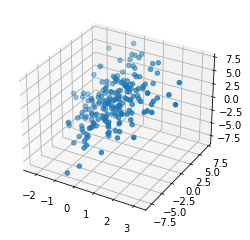

In [6]:
true_w = torch.tensor([1., 1.])
X, y = initial(config, true_w, scale=2.5)
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), y.numpy())
plt.show()

# from scratch

In [7]:
def data_iter(X, y, batch_size=10):
    m = len(X)
    indices = torch.randperm(m)
    for i in range(0, m, batch_size):
        batch_indices = indices[i:min(i + batch_size, m)]
        yield X[batch_indices], y[batch_indices]

In [8]:
def linreg(X, w):
    return X @ w

In [9]:
def squared_loss(y_hat, y):
    return ((y_hat - y) ** 2).mean(dim=0)

In [10]:
# def sgd(params, lr):
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad
#             param.grad.zero_()

In [11]:
# def train(model, loss, X, y):
#     epochs = config["epochs"]
#     lr = config["lr"]
#     batch_size = config["batch_size"]
#     n = config["n"]

#     # w = torch.normal(0, 0.01, (n,), requires_grad=True)
#     w = torch.tensor([true_w[0].item() - 2.5, true_w[1].item() - 2.5], requires_grad=True)
#     # b = torch.rand((1,), requires_grad=True)
#     params = [w]

#     epoch = 0

#     loss_record = {"train": [], "dev": []}

#     trace = [w.detach().cpu().numpy().copy()]
#     print(trace)
    
#     while epoch < epochs:
#         for X_sample, y_sample in data_iter(X, y, batch_size):
#             l = loss(model(X_sample, w), y_sample)
#             l.backward()
#             sgd(params, lr)

#             loss_record['train'].append(l.detach().item())
#             trace.append(w.detach().cpu().numpy().copy())

#         epoch += 1

#         lr *= 0.9

#         with torch.no_grad():
#             train_l = loss(model(X, w), y)
#             print(f"epoch: {epoch:3d}, loss: {train_l: .7f}")
    
#     return trace

In [12]:
# trace = train(linreg, squared_loss, X, y)
# w1, w2 = trace[-1]

In [13]:
# w1, w2

In [14]:
(w1_minima, w2_minima), minima = formal_sol(X, y)
(w1_minima, w2_minima), minima

((tensor(0.9377), tensor(0.9977)), tensor(0.2597))

In [15]:
def visualization(trace):
    fig = plt.figure(figsize=(12, 6))

    gs = GridSpec(2, 2, width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[:, 1], projection='3d')
    ax2 = fig.add_subplot(gs[:, 0])
    # ax3 = fig.add_subplot(gs[1, 0])


    x1, x2 = torch.meshgrid(torch.linspace(true_w[0].item() - 2.6, true_w[0].item() + 2.6, 30),
                            torch.linspace(true_w[1].item() - 2.6, true_w[1].item() + 2.6, 30))


    x = torch.cat([x1.reshape(-1, 1), x2.reshape(-1, 1)], dim=1)
    z = squared_loss(linreg(X, x.T), y.reshape(-1, 1)).reshape(30, -1)

    ax1.plot_surface(x1.numpy(), x2.numpy(), z.numpy(), cmap='viridis', alpha=0.7)
    ax1.scatter(w1_minima.item(), w2_minima.item(), minima, c='red', s=100, marker='x')
    ax1.plot3D(*zip(*trace), [squared_loss(linreg(X, w), y) for w in trace], c='r', marker='o')

    ax1.set_title('Loss Surface', fontsize=16)
    ax1.set_xlabel('w1') 
    ax1.set_ylabel('w2')
    ax1.set_zlabel('Loss')
    ax1.view_init(40, 10)


    ax2.contour(x1.numpy(), x2.numpy(), z.numpy(), 20, colors='#1f77b4')
    ax2.plot(*zip(*trace), '-o', color='#ff7f0e')
    ax2.scatter(w1_minima.item(), w2_minima.item(), marker='x', s=100, color='r', label="global minima")
    # ax2.axes.get_xaxis().set_visible(False)
    # ax2.axes.get_yaxis().set_visible(False)
    ax2.set_title('Loss Contour', fontsize=16)
    ax2.set_xlabel('w1') 
    ax2.set_ylabel('w2')
    ax2.legend()
    ax2.axis('equal')

    plt.show()

# Consice

In [16]:
def prep_dataloader(X, y, mode, batch_size):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size, shuffle=(mode == 'train'))

In [17]:
tr_set = prep_dataloader(X, y, 'train', config['batch_size'])

In [18]:
class Linreg(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(n_features, 1))
        
        # self.net[0].weight.data.normal_(0, 0.01)
        self.net[0].weight.data.fill_(-1.5)

        # self.net[0].bias.data.fill_(torch.rand(1,).item())
        self.net[0].bias.data.fill_(0)

        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, X):
        return self.net(X).squeeze(1)

    def cal_loss(self, y_hat, y):
        return self.criterion(y_hat, y)

In [19]:
def train(model, tr_set):
    epochs = config["epochs"]


    # optimizer = getattr(torch.optim, config["optimizer"])(
    #     model.parameters(), **config["optim_hparas"]
    # )
    
    optimizer = getattr(torch.optim, config["optimizer"])(
        [model.net[0].weight], **config["optim_hparas"]
    )

    epoch = 0

    loss_record = {"train": [], "dev": []}
    trace = [model.net[0].weight.data.numpy().copy()[0]]

    animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.2, 1.5], 
                            legend=['train loss', 'test loss'])

    while epoch < epochs:
        model.train()
        for X_sample, y_sample in tr_set:
            optimizer.zero_grad()
            l = model.cal_loss(model(X_sample), y_sample)
            l.backward()
            optimizer.step()
            loss_record['train'].append(l.detach().item())

            trace.append(model.net[0].weight.data.numpy().copy()[0])

        epoch += 1
        
        with torch.no_grad():
            train_l = dev(model, tr_set)
            # train_l = model.cal_loss(model(X), y)
            animator.add(epoch, (train_l, ))
#             print(f"epoch: {epoch:3d}, loss: {train_l: .4f}")
    
    return trace

In [20]:
def dev(model, dev_set):
    model.eval()
    total_loss = 0
    
    for X, y in tr_set:
         total_loss += model.cal_loss(model(X), y) * len(X)
    total_loss /= len(dev_set.dataset)
    
    return total_loss

In [21]:
model = Linreg(config["n"])

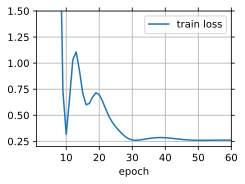

In [22]:
trace = train(model, tr_set)

In [23]:
# with torch.no_grad():
#     plt.scatter(X[:, 0].numpy(), y.numpy(), 10)
#     x = torch.linspace(-3, 3, 20).reshape(-1, 1)
#     plt.plot(x.numpy(), model(x).numpy(), '-r')

In [24]:
model.net[0].weight.data, model.net[0].bias.data

(tensor([[0.9815, 0.9965]]), tensor([0.]))

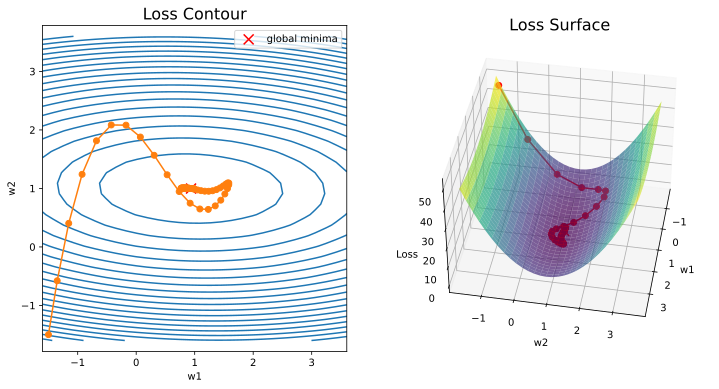

In [25]:
visualization(trace)